In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Модели из sklearn
from xgboost import XGBRegressor
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support

## Load data

In [2]:
df = pd.read_csv("/content/heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [33]:
df.shape

(1025, 14)

## Построить и оценить качество бейзлайна

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
# Split data into X and Y
X = df.drop('target', axis=1)

y = df['target']

## Произведено разбиение датасета на тернировочную/тестовую выборки

In [8]:
# Разделите набор на обучающий и тестовый набор и установите случайное состояние на 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть

In [55]:
# Помещаем модели в словарь
models = {"XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, objective='reg:squarederror'),
          "CatBoost": CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_seed=42),
          "Random Forest": RandomForestClassifier(random_state=42)}

# Мы создаем функцию для подбора и оценки моделей
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """Соответствует и оценивает заданные модели машинного обучения.
    Параметры:
    модели: список различных моделей машинного обучения Scikit-Learn.
    X_train: данные обучения (без меток)
    X_test: данные тестирования (без меток)
    y_train: данные обучения
    y_test: данные тестирования

    Возврат:
    Словарь моделей и их оценок
    """
    # Создать словарь для хранения оценок моделей.
    model_scores = {}

    # LПеребирать модели
    for name, model in models.items():
        if name == "XGBoost":
          np.random.seed(42)
        # Подогнать модель к данным
        model.fit(X_train, y_train)
        # Оценить модель и добавить ее оценку в словарь model_scores.
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [ ]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

In [57]:
model_scores

{'XGBoost': 0.9374779327869233,
 'CatBoost': 0.9853658536585366,
 'Random Forest': 0.9853658536585366}

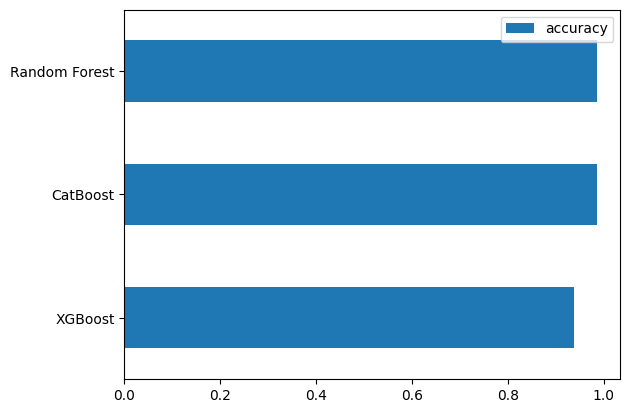

In [58]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])

model_compare.T.plot.barh();

## Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики

In [61]:
def f1_for_regressors(models, X_test, y_test):
    """
    Вычисляет оценки типа F1 для нескольких моделей регрессии и возвращает их в виде словаря.

    Аргументы:
        модели: список обученных регрессионных моделей.
        X_test: Тестовые функции.
        y_test: целевые значения теста.

    Возврат:
        Словарь, содержащий названия моделей и соответствующие им оценки, подобные F1.
    """

    f1_scores = {}
    for model_name, model in models.items():
      predictions = model.predict(X_test)
      if model_name == "XGBoost":
        precision, recall, _, _ = precision_recall_fscore_support(y_test, predictions >= y_test - 0.1, average='binary')
        f1 = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)
      else:
        f1 = f1_score(y_test, predictions)
      f1_scores[model_name] = f1

    return f1_scores

In [62]:
f1_scores = f1_for_regressors(models, X_test, y_test)
print("F1-like scores:", f1_scores)

F1-like scores: {'XGBoost': 0.6423841059602649, 'CatBoost': 0.9852216748768473, 'Random Forest': 0.9852216748768473}


In [65]:
f1_scores

{'XGBoost': 0.6423841059602649,
 'CatBoost': 0.9852216748768473,
 'Random Forest': 0.9852216748768473}

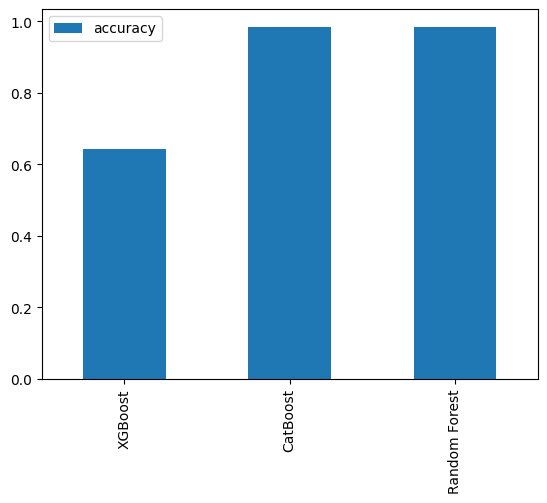

In [67]:
f1_compare = pd.DataFrame(f1_scores, index=["accuracy"])

f1_compare.T.plot.bar();

## Принимаемые решения обоснованы и прокомментированы в markdown ячейках (то есть, например, если для кодирования категориальных переменных выбран метод Label Encoding, то текстом написано, почему он, и тп)

Поскольку у нас не было категориальных данных, мы не выполняли категориальных переменных.